In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 1.9.0
torchvision version: 0.10.0


In [26]:
import numpy as np
import os
import time
import wandb
import IPython.display
from IPython.display import display
from PIL import Image

In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [6]:
wandb.login()

True

In [7]:
data_root = os.path.expanduser('~/ml_datasets/')
path_to_dataset = os.path.join(data_root, 'cifar10')

## Define the parameters

In [8]:
config_dict = {
    'batch_size': 32,
    'num_epochs': 20,
    'learning_rate': 0.003,
    'base_lr': 0.001,
    'max_lr': 0.05
}

## Define the data

In [9]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)

batch_size = config_dict['batch_size']

# data for training
train_dataset = torchvision.datasets.CIFAR10(
    path_to_dataset,
    transform=transform,
    download=True,    
    train=True,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# data for testing
test_dataset = torchvision.datasets.CIFAR10(
    path_to_dataset,
    transform=transform,
    download=True,    
    train=False,    
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
images, labels = next(iter(train_dataloader))

In [12]:
type(images), images.shape, type(labels), labels.shape

(torch.Tensor, torch.Size([32, 3, 32, 32]), torch.Tensor, torch.Size([32]))

## Define a convolutional neural network

In [13]:
class LeNet5(nn.Module):
    
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # output shape: (N, 6, 28, 28)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # output shape: (N, C=6, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # output shape: (N, 16, 10, 10)
        # self.pool will also be applied after self.conv2, the second pooling makes the output shape: (N, 16, 5, 5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [14]:
lenet5 = LeNet5()

In [16]:
logits = lenet5(images)
print(f'input shape: {images.shape}, output shape: {logits.shape}')

input shape: torch.Size([32, 3, 32, 32]), output shape: torch.Size([32, 10])


## Define objects to keep track of metrics during training

In [17]:
class Mean(object):
    """
    Vanilla version of tf.keras.metrics.Mean
    """

    def __init__(self):
        self.value = 0.
        self.n = 0

    def __call__(self, value):
        self.value += value
        self.n += 1

    def reset_state(self):
        self.value = 0.
        self.n = 0

    def result(self):
        return self.value / float(self.n)


class SparseCategoricalAccuracy(object):
    """
    Vanilla version of tf.keras.metrics.SparseCategoricalAccuracy
    """

    def __init__(self):
        self.hits = 0
        self.total = 0

    def __call__(self, logits, targets):
        self.hits += (torch.argmax(logits, dim=1) == targets).sum().item()
        self.total += logits.size(0)

    def reset_state(self):
        self.hits = 0
        self.total = 0

    def result(self):
        return float(self.hits) / float(self.total)


## Define an training loop

In [18]:
def make_model(config_dict):
    model = LeNet5()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    loss_func = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer, 
        base_lr=config_dict['base_lr'], 
        max_lr=config_dict['max_lr'],
        mode='triangular2'
    )
    
    return model, optimizer, scheduler, loss_func


In [19]:
def run_one_epoch(dataloader, model, optimizer, scheduler, loss_func, training=True):
    loss_metric = Mean()
    acc_metric = SparseCategoricalAccuracy()
    for images, labels in dataloader:
        if training:
            optimizer.zero_grad()
            logits = model(images)
            batch_loss = loss_func(logits, labels)
            batch_loss.backward()
            optimizer.step()
            scheduler.step()
        else:
            with torch.no_grad():
                logits = model(images)
                batch_loss = loss_func(logits, labels)
                
        loss_metric(batch_loss)
        acc_metric(logits, labels)
    
    return loss_metric.result(), acc_metric.result()
                

In [20]:
def train_model(train_dataloader, test_dataloader, model, optimizer, scheduler, loss_func, config_dict):
    
    wandb.watch(model, loss_func, log="all", log_freq=1)
    
    for epoch_idx in range(config_dict['num_epochs']):
        model.train()
        train_loss, train_acc = run_one_epoch(train_dataloader, model, optimizer, scheduler, loss_func, True)
        
        model.eval()
        test_loss, test_acc = run_one_epoch(test_dataloader, model, None, None, loss_func, False)
        
        wandb.log(
            {'epoch': epoch_idx,
             'train_loss': train_loss,
             'train_acc': train_acc,
             'test_loss': test_loss,
             'test_acc': test_acc,
             'lr': scheduler.get_last_lr()[0]
            },
            step=epoch_idx
        )
        
        if (epoch_idx+1) % 5 == 0:
            print(f'finished epoch {epoch_idx}, train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f},  test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}, last_lr: {scheduler.get_last_lr()[0]:.5f}')
                                        

In [21]:
def run(train_dataloader, test_dataloader, config_dict, path_to_model=None):
        
    with wandb.init(project='CIFAR10-LeNet5-PyTorch', config=config_dict):
        model, optimizer, scheduler, loss_func = make_model(config_dict)
        train_model(train_dataloader, test_dataloader, model, optimizer, scheduler, loss_func, config_dict)
        
        if path_to_model is not None:
            torch.save(model.state_dict(), path_to_model)
            loaded_model = LeNet5()
            loaded_mode.load_state_dict(torch.load(path_to_model))


In [ ]:
run(train_dataloader, test_dataloader, config_dict)

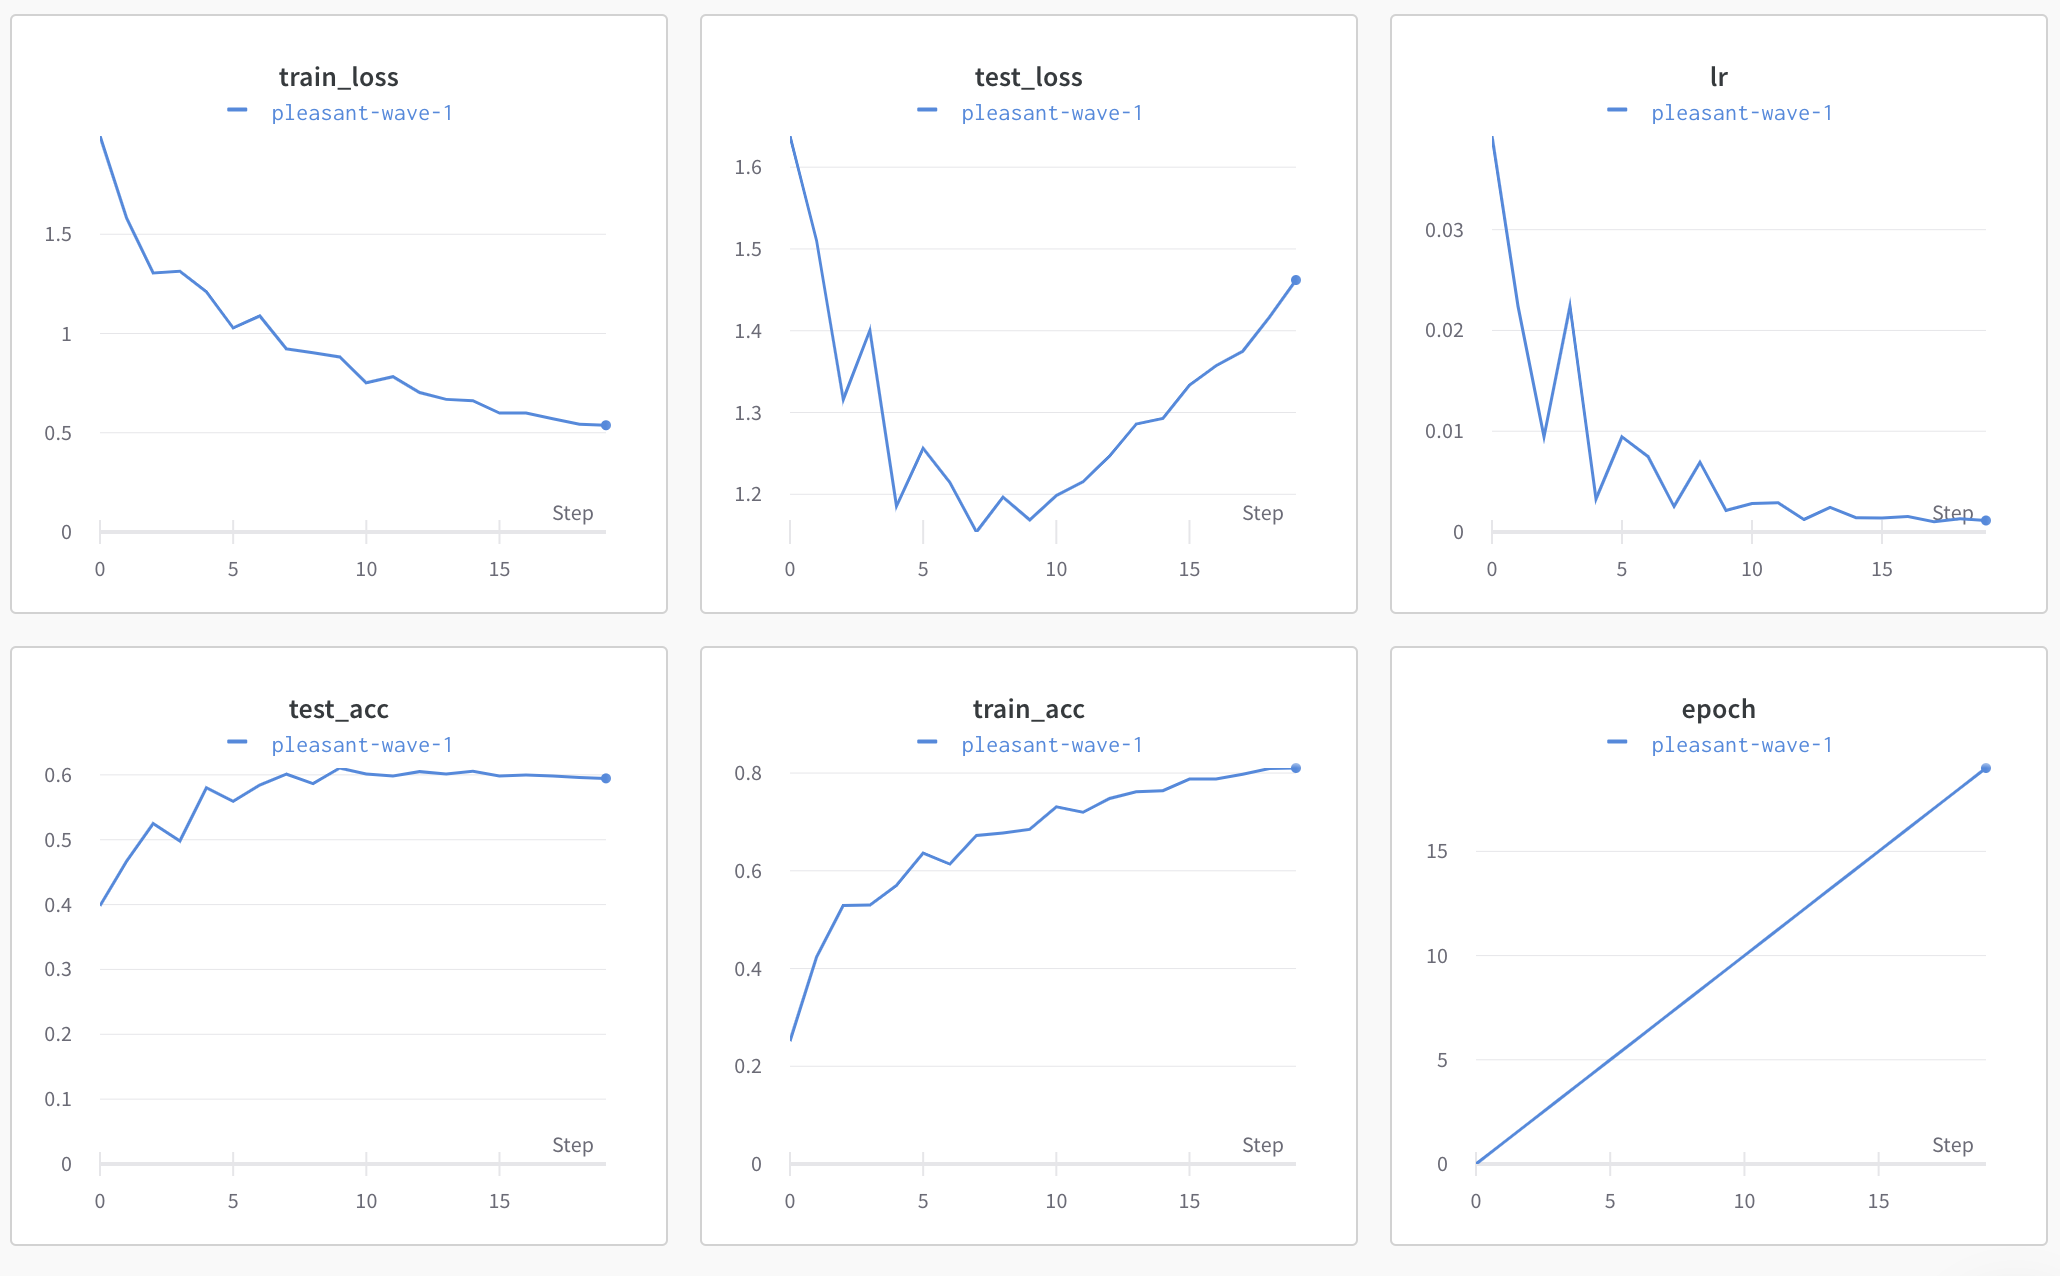

In [28]:
IPython.display.Image(filename='LeNet5_CIFAR10_WandB_dashboard.png') #, width=100, height=100)